In [83]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import datetime
from datetime import datetime date

### 1. Import claims_data.csv and cust_data.csv which is provided to you and combine the two datasets appropriately to create a 360-degree view of the data. Use the same for the subsequent questions.

In [84]:
claim=pd.read_csv('claims.csv')
claim.head(2)

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No


In [85]:
claim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   claim_id             1100 non-null   int64  
 1   customer_id          1100 non-null   int64  
 2   incident_cause       1100 non-null   object 
 3   claim_date           1100 non-null   object 
 4   claim_area           1100 non-null   object 
 5   police_report        1100 non-null   object 
 6   claim_type           1100 non-null   object 
 7   claim_amount         1035 non-null   object 
 8   total_policy_claims  1090 non-null   float64
 9   fraudulent           1100 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 86.1+ KB


In [86]:
cust_data=pd.read_csv('cust_demographics.csv')
cust_data.head(2)

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver


In [87]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CUST_ID      1085 non-null   int64 
 1   gender       1085 non-null   object
 2   DateOfBirth  1085 non-null   object
 3   State        1085 non-null   object
 4   Contact      1085 non-null   object
 5   Segment      1085 non-null   object
dtypes: int64(1), object(5)
memory usage: 51.0+ KB


In [88]:
#?pd.merge

In [89]:
insurance=pd.merge(cust_data,claim, left_on='CUST_ID' ,right_on='customer_id',  how='inner', indicator=True)

In [90]:
insurance.head(10)

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,_merge
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No,both
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No,both
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1.0,Yes,both
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,63017412,30308357,Driver error,04/04/2018,Auto,No,Material only,$1950,6.0,No,both
4,47830476,Female,01-May-86,MA,413-187-7945,Silver,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1.0,No,both
5,47830476,Female,01-May-86,MA,413-187-7945,Silver,91609100,47830476,Natural causes,04/12/2017,Auto,Unknown,Material only,$1440,1.0,No,both
6,19269962,Male,13-May-77,NV,956-871-8691,Gold,22890252,19269962,Crime,01/13/2018,Auto,No,Material only,$2680,1.0,No,both
7,19269962,Male,13-May-77,NV,956-871-8691,Gold,39219616,19269962,Other causes,09/26/2018,Auto,No,Material only,$2240,2.0,No,both
8,21831191,Male,17-May-77,NH,419-712-8513,Gold,24050443,21831191,Other driver error,10/04/2017,Auto,No,Injury only,$38306.5,3.0,Yes,both
9,21831191,Male,17-May-77,NH,419-712-8513,Gold,91475471,21831191,Driver error,02/09/2018,Auto,Unknown,Material and injury,$36810,1.0,No,both


In [91]:
Data=insurance.drop(columns='_merge')
Data.dropna(inplace=True)

### Q2. Perform a data audit for the datatypes and find out if there are any mismatch within the current datatypes of the columns and their business significance

In [92]:
## Create UDFs

In [93]:
def conti_var_summary(x):
    return pd.Series([x.count(),x.isnull(),x.sum(),x.mean(),x.median(),x.min(),x.quantile(0.01),x.quantile(0.99),x.max()],
                    index=['N','Missing','Sum','Mean','Median','Min','P1','P99','Max'])

In [94]:
def categorical_var_summary(x):
    Mode=x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([x.count(),x.isnull(),Mode.iloc[0,0],Mode.iloc[0,1],round(Mode.iloc[0,1]*100/x.count(),2)],
                    index=['N','Missing','Mode','FREQ','Percentage'])

In [95]:
def missing_immputation(x,stat='mean'):
    if (x.dtypes=='float64' | x.dtypes=='int64'):
        x=x.fillna(x.mean())  if stat=='mean' else x.fillna(x,median())
    else:
        x=x.fillna(x.mode())
    return(x)
            

In [130]:
insu_claim_conti_vars = Data.loc[:, (Data.dtypes == 'float64') | (Data.dtypes == 'int64')]
insu_claim_cat_vars = Data.loc[:, (Data.dtypes == 'object') | (Data.dtypes == 'str')]

In [98]:
 ##insurance_conti_vars = Data.select_dtypes(include = ['float64', 'int64'])
#insurance_cat_vars = Data.select_dtypes(include = ['object'])

In [102]:
insu_claim_conti_vars.apply(conti_var_summary).round(1).T

,N,Missing,Sum,Mean,Median,Min,P1,P99,Max
CUST_ID,1011,0 False 1 False 2 False 3 ...,51164372927,50607688.355094,49428676.0,263204,1169469.0,98329304.5,99961993
claim_id,1011,0 False 1 False 2 False 3 ...,49175612829,48640566.596439,48203523.0,26832,1259106.1,98934172.1,99775483
customer_id,1011,0 False 1 False 2 False 3 ...,51164372927,50607688.355094,49428676.0,263204,1169469.0,98329304.5,99961993
total_policy_claims,1011,0 False 1 False 2 False 3 ...,1607.0,1.589515,1.0,1.0,1.0,6.0,8.0


In [101]:
insu_claim_cat_vars.apply(categorical_var_summary).T

,N,Missing,Mode,FREQ,Percentage
gender,1011,0 False 1 False 2 False 3 ...,Male,516,51.04
DateOfBirth,1011,0 False 1 False 2 False 3 ...,11-Mar-84,2,0.2
State,1011,0 False 1 False 2 False 3 ...,NY,30,2.97
Contact,1011,0 False 1 False 2 False 3 ...,798-631-4758,2,0.2
Segment,1011,0 False 1 False 2 False 3 ...,Gold,347,34.32
incident_cause,1011,0 False 1 False 2 False 3 ...,Other causes,263,26.01
claim_date,1011,0 False 1 False 2 False 3 ...,04/04/2018,18,1.78
claim_area,1011,0 False 1 False 2 False 3 ...,Auto,905,89.52
police_report,1011,0 False 1 False 2 False 3 ...,No,573,56.68
claim_type,1011,0 False 1 False 2 False 3 ...,Material only,605,59.84


## 3. Convert the column claim_amount to numeric. Use the appropriate odules/attributes remove the $ sign

In [110]:
Data['claim_amount']=Data['claim_amount'].astype(str)
Data['claim_amount']=Data['claim_amount'].str.replace('$','')
Data['claim_amount']=pd.to_numeric(Data['claim_amount'])
Data

C:\Users\Sarita\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,2980.0,1.0,No
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,2980.0,3.0,No
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,3369.5,1.0,Yes
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,63017412,30308357,Driver error,04/04/2018,Auto,No,Material only,1950.0,6.0,No
4,47830476,Female,01-May-86,MA,413-187-7945,Silver,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,1680.0,1.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum,62020796,79539873,Other driver error,09/06/2018,Auto,Yes,Material only,1770.0,1.0,No
1081,42364152,Female,07-Jul-96,ID,529-462-1635,Silver,63269067,42364152,Other causes,05/09/2017,Home,No,Material only,2800.0,1.0,No
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold,22690595,19888166,Other driver error,05/15/2017,Auto,Yes,Injury only,33080.0,2.0,No
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver,12376894,11256802,Other driver error,04/18/2017,Auto,No,Material only,2840.0,4.0,No


### 4. Of all the injury claims, some of them have gone unreported with the police. Create an alert flag (1,0) for all such claims.

In [112]:
Data['Flag']=np.where(Data.police_report == 'Unknown', 0,1)
Data

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,Flag
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,2980.0,1.0,No,1
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,2980.0,3.0,No,0
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,3369.5,1.0,Yes,1
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,63017412,30308357,Driver error,04/04/2018,Auto,No,Material only,1950.0,6.0,No,1
4,47830476,Female,01-May-86,MA,413-187-7945,Silver,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,1680.0,1.0,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum,62020796,79539873,Other driver error,09/06/2018,Auto,Yes,Material only,1770.0,1.0,No,1
1081,42364152,Female,07-Jul-96,ID,529-462-1635,Silver,63269067,42364152,Other causes,05/09/2017,Home,No,Material only,2800.0,1.0,No,1
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold,22690595,19888166,Other driver error,05/15/2017,Auto,Yes,Injury only,33080.0,2.0,No,1
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver,12376894,11256802,Other driver error,04/18/2017,Auto,No,Material only,2840.0,4.0,No,1


### 5. One customer can claim for insurance more than once and in each claim,multiple categories of claims can be involved. However, customer ID should remain unique.Retain the most recent observation and delete any duplicated records in the data based on the customer ID column.

In [126]:
##Data[Data.customer_id == Data.CUST_ID]
Data.drop_duplicates(subset='CUST_ID' , keep='last')

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,Flag
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,2980.0,1.0,No,1
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,2980.0,3.0,No,0
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,63017412,30308357,Driver error,04/04/2018,Auto,No,Material only,1950.0,6.0,No,1
5,47830476,Female,01-May-86,MA,413-187-7945,Silver,91609100,47830476,Natural causes,04/12/2017,Auto,Unknown,Material only,1440.0,1.0,No,0
7,19269962,Male,13-May-77,NV,956-871-8691,Gold,39219616,19269962,Other causes,09/26/2018,Auto,No,Material only,2240.0,2.0,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum,62020796,79539873,Other driver error,09/06/2018,Auto,Yes,Material only,1770.0,1.0,No,1
1081,42364152,Female,07-Jul-96,ID,529-462-1635,Silver,63269067,42364152,Other causes,05/09/2017,Home,No,Material only,2800.0,1.0,No,1
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold,22690595,19888166,Other driver error,05/15/2017,Auto,Yes,Injury only,33080.0,2.0,No,1
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver,12376894,11256802,Other driver error,04/18/2017,Auto,No,Material only,2840.0,4.0,No,1


### 6. Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)

In [131]:
insu_claim_conti_vars=insu_claim_conti_vars.apply(missing_immputation)
insurance_cat_vars=insu_claim_cat_vars.apply(missing_immputation)

TypeError: unsupported operand type(s) for |: 'str' and 'numpy.dtype'

### 7. Calculate the age of customers in years. Based on the age, categorize the customers according to the below criteriaChildren < 18Youth 18-30Adult 30-60Senior > 60

In [136]:
from datetime import datetime, date

In [137]:
def age(born): 
    born = datetime.strptime(born, "%d-%b-%y").date() 
    today = date.today() 
    return today.year - born.year - ((today.month,  
                                      today.day) < (born.month,  
                                                    born.day))

In [138]:
Data['Age'] = Data['DateOfBirth'].apply(age) 
display(Data)

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,Flag,Age
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,2980.0,1.0,No,1,42
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,2980.0,3.0,No,0,51
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,3369.5,1.0,Yes,1,37
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,63017412,30308357,Driver error,04/04/2018,Auto,No,Material only,1950.0,6.0,No,1,37
4,47830476,Female,01-May-86,MA,413-187-7945,Silver,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,1680.0,1.0,No,1,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum,62020796,79539873,Other driver error,09/06/2018,Auto,Yes,Material only,1770.0,1.0,No,1,40
1081,42364152,Female,07-Jul-96,ID,529-462-1635,Silver,63269067,42364152,Other causes,05/09/2017,Home,No,Material only,2800.0,1.0,No,1,25
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold,22690595,19888166,Other driver error,05/15/2017,Auto,Yes,Injury only,33080.0,2.0,No,1,31
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver,12376894,11256802,Other driver error,04/18/2017,Auto,No,Material only,2840.0,4.0,No,1,-44


In [141]:
Data.loc[(Data.Age < 18),'AgeGroup'] = 'Children'
Data.loc[(Data.Age >=18) & (Data.Age <30),'AgeGroup'] = 'Youth'
Data.loc[(Data.Age >=30) & (Data.Age <60),'AgeGroup'] = 'Adult'
Data.loc[(Data.Age >=60),'AgeGroup'] = 'Senior'

Data

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,Flag,Age,AgeGroup
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,2980.0,1.0,No,1,42,Adult
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,2980.0,3.0,No,0,51,Adult
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,3369.5,1.0,Yes,1,37,Adult
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,63017412,30308357,Driver error,04/04/2018,Auto,No,Material only,1950.0,6.0,No,1,37,Adult
4,47830476,Female,01-May-86,MA,413-187-7945,Silver,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,1680.0,1.0,No,1,35,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum,62020796,79539873,Other driver error,09/06/2018,Auto,Yes,Material only,1770.0,1.0,No,1,40,Adult
1081,42364152,Female,07-Jul-96,ID,529-462-1635,Silver,63269067,42364152,Other causes,05/09/2017,Home,No,Material only,2800.0,1.0,No,1,25,Youth
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold,22690595,19888166,Other driver error,05/15/2017,Auto,Yes,Injury only,33080.0,2.0,No,1,31,Adult
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver,12376894,11256802,Other driver error,04/18/2017,Auto,No,Material only,2840.0,4.0,No,1,-44,Children


### 8. What is the average amount claimed by the customers from various segments?


In [145]:
Data.groupby('Segment').mean()[['claim_amount']].round(2)

,claim_amount
Segment,
Gold,12723.93
Platinum,12397.86
Silver,12218.00


### 9. What is the total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 2018.

In [150]:
Data.groupby('incident_cause')[(Data.claim_date > '1/oct/18')]

KeyError: 'Columns not found: False, True'

### 10. How many adults from TX, DE and AK claimed insurance for driver  related issues and causes? 

In [208]:
Data.head(1)

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,Flag,Age,AgeGroup,Claim_date
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,54004764,21868593,Driver error,1,Auto,No,Material only,2980.0,1.0,No,1,42,Adult,1


In [157]:
count = Data.loc[((Data.State == 'TX') | (Data.State == 'DE') | (Data.State == 'AK')) & (Data.incident_cause == 'Driver error') & (Data.AgeGroup == 'Adult'),['AgeGroup']].count()
count

AgeGroup    11
dtype: int64

### 11. Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage on the pie chart.

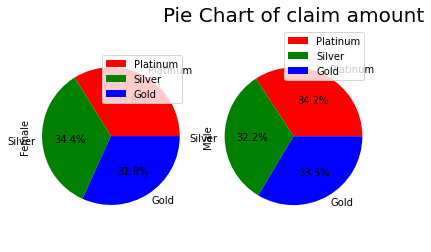

In [162]:
import matplotlib.pyplot as plt

claim = pd.pivot_table(Data, index =['Segment'],columns ='gender',values ='claim_amount')


claim.plot(kind='pie', 
            labels=['Platinum','Silver','Gold'],
            colors=['r', 'g', 'b'],
            autopct='%.1f%%', # to get percentage and round off appropriately
            fontsize=10,
            subplots='true')

plt.title('Pie Chart of claim amount',fontsize=20)


plt.axis('equal')
plt.show()

### 12. Among males and females, which gender had claimed the most for any type of driver related issues? E.g. This metric can be compared using a bar chart

In [178]:
issue = Data.loc[Data['incident_cause'].isin(['Driver error','Other driver error'])]

In [184]:
issue = Data.loc[Data['incident_cause'].isin(['Driver error','Other driver error'])]
group_gender = issue.groupby(['gender'])['claim_amount'].sum()
group_gender.nlargest(1)


gender
Male    3762289.0
Name: claim_amount, dtype: float64

<AxesSubplot:xlabel='gender'>

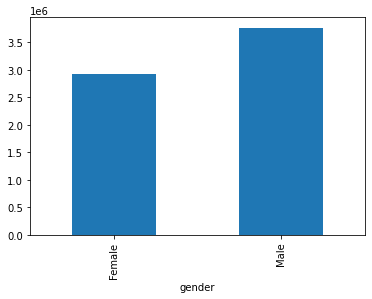

In [186]:
group_gender.plot(kind='bar')

### 13. Which age group had the maximum fraudulent policy claims? Visualize it on a bar chart

<AxesSubplot:xlabel='AgeGroup'>

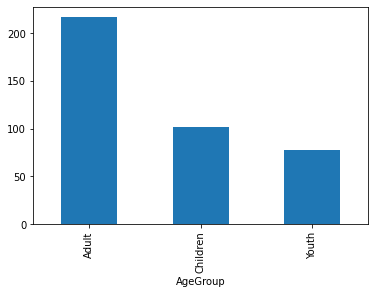

In [192]:
issue1=Data.loc[Data['fraudulent'] =='Yes']
age_grp=issue1.groupby(['AgeGroup'])['total_policy_claims'].sum()
age_grp.plot(kind='bar')

### 14. Visualize the monthly trend of the total amount that has been claimed by the customers. Ensure that on the “month” axis, the month is in a chronological order not alphabetical order. 

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [197]:
Data['claim_date']=pd.to_datetime(Data['claim_date']).dt.month
sns.set()

pd.pivot_table(Data,index='',columns='Claim_Date',values='claim_amount').plot(kind='bar')
plt.ylabel('Total Amount')
plt.show()

KeyError: ''

In [198]:
Data['claim_date'] = pd.to_datetime(Data['claim_date'])
Data['Claim_date'] = Data['claim_date'].dt.month
sns.set()
pd.pivot_table(Data, index ='',columns ='Claim_date',values="claim_amount").plot(kind='bar')
plt.ylabel('Total amount spend')
plt.show()

KeyError: ''

#### Based on the conclusions from exploratory analysis as well as suitable statistical tests, answer the below questions. Please include a detailed write-up on the parameters taken into consideration, the Hypothesis testing steps, conclusion from the p-values and the business implications of the statements. 

#### 16. Is there any similarity in the amount claimed by males and females?

In [220]:
import scipy.stats as stats

In [223]:
Claim_male=Data.claim_amount[Data.gender== 'Male'].mean()
Claim_Female=Data.claim_amount[Data.gender== 'Female'].mean()
print("Total Amount Claim By Male :" ,Claim_male)
print("Total Amount Claim By Female :" ,Claim_Female)

Total Amount Claim By Male : 12855.763565891473
Total Amount Claim By Female : 12033.19393939394


In [229]:
 stats.ttest_ind(a= Claim_male,
                b= Claim_Female) 

Ttest_indResult(statistic=nan, pvalue=nan)

#### 17. Is there any relationship between age category and segment?


#### Chi Test

In [233]:
age_seg=pd.crosstab(Data.AgeGroup,Data.Segment)
age_seg

Segment,Gold,Platinum,Silver
AgeGroup,,,
Adult,201,186,171
Children,76,77,77
Youth,70,82,71


In [234]:
stats.chi2_contingency(observed=age_seg)

(2.1476062933507696,
 0.7086319800974464,
 4,
 array([[191.51928783, 190.41543027, 176.0652819 ],
        [ 78.94164194,  78.48664688,  72.57171118],
        [ 76.53907023,  76.09792285,  70.36300692]]))

p value is greater then 0.05 so we fail to reject the null Hypothesis So there is no association between the two groups

#### 18. The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.


#### 19. Is there any difference between age groups and insurance claims?

In [239]:
policy_claim_adult=Data.total_policy_claims[Data.AgeGroup== 'Adult'].mean()
policy_claim_youth=Data.total_policy_claims[Data.AgeGroup== 'Youth'].mean()
#policy_claim_youth=Data.total_policy_claims[Data.AgeGroup== 'Youth'].mean()
print('Total Claim for Adult',policy_claim_adult)
print('Total Claim for youth',policy_claim_youth)

Total Claim for Adult 1.5842293906810037
Total Claim for youth 1.6591928251121075


In [240]:
anova = stats.f_oneway(policy_claim_adult,policy_claim_youth)

ValueError: zero-dimensional arrays cannot be concatenated

In [242]:
age_group_1 = Data['total_policy_claims'].loc[Data['AgeGroup']=="Youth"]
age_group_2 = Data['total_policy_claims'].loc[Data['AgeGroup']=="Adult"]
# Perfrom the Anova
anova = stats.f_oneway(age_group_1,age_group_2)
# Statistic :  F Value
f = anova.statistic
p = anova.pvalue
print("The f-value is {} and the p value is {}".format(f,p))
if(p<0.05):
    print('We reject null hypothesis')
else:
    print('We fail to reject null hypothesis')

The f-value is 0.6644833701938648 and the p value is 0.415230739000677
We fail to reject null hypothesis


#### 20. Is there any relationship between total number of policy claims and the claimed amount?


In [243]:
stats.pearsonr(Data.total_policy_claims, Data.claim_amount)

(-0.018086586789599398, 0.5656831148630601)

In [245]:
'Strong' if stats.pearsonr(Data.total_policy_claims, Data.claim_amount)[0] > 0.5 else 'Weak'

'Weak'

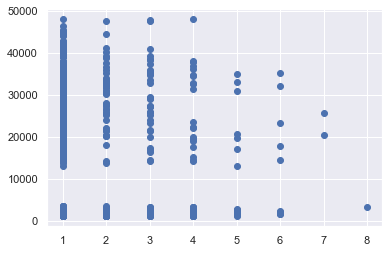

In [244]:
plt.scatter(Data.total_policy_claims, Data.claim_amount)